In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fftn, ifftn, fftshift, ifftshift

np.random.seed(40)

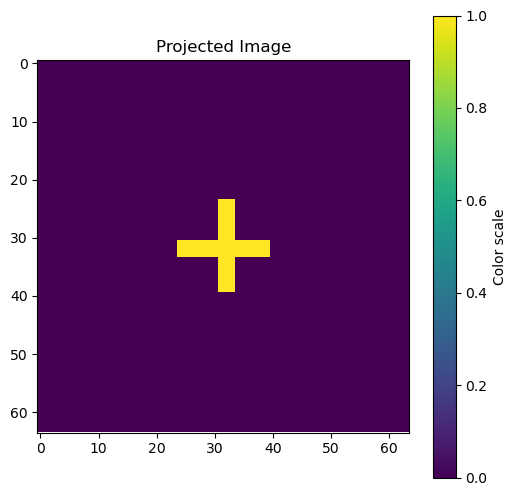

In [2]:
size = 64
x = np.linspace(-5, 5, size)
y = np.linspace(-5, 5, size)

# Create a meshgrid from x and y
X, Y = np.meshgrid(x, y)

target = np.zeros((size, size))
width = size // 48
center_x = size // 2
center_y = size // 2
target[center_x - width: center_x + width + 1, 24: 40] = 1
target[24: 40, center_y - width: center_y + width + 1] = 1.0

plt.figure(figsize=(6,6))
plt.imshow(target, cmap='viridis')
plt.colorbar(label='Color scale')
plt.title('Projected Image')
plt.show()

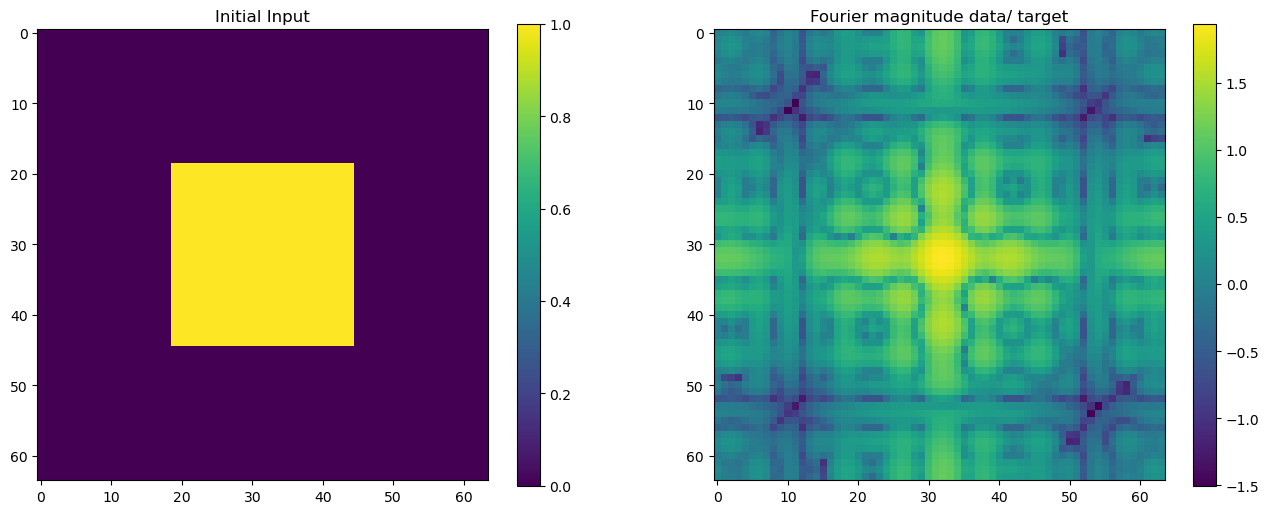

In [3]:
# fourier transform the cross shaped
X_true = fftn(target)
M_true = np.abs(X_true)

supp = np.zeros((size, size))
axis_range_x = (X >= -2) & (X <= 2)
axis_range_y = (Y >= -2) & (Y <= 2)
supp[axis_range_x & axis_range_y] = 1.0

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
im = ax.imshow(supp)
plt.colorbar(im)
ax.set_title('Initial Input')

# this is just to check the target
ax = fig.add_subplot(122)
im = ax.imshow(np.log10(fftshift(M_true)))
plt.colorbar(im)
ax.set_title('Fourier magnitude data/ target')

plt.show()

In [4]:
def P_S(x, S_in):
    x_new = x * S_in['supp']
    
    return x_new

In [5]:
def P_M(x, M_in):
    X = fftn(x)
    
    X_new = X/np.abs(X) * M_in['M_data']
#     X_new = M_in['M_data'] * np.exp(1j * np.angle(X))
    
    x_new = ifftn(X_new)
    return x_new

# Difference Map

In [6]:
def R_M(x, gamma_M, M_in):
    return (1+gamma_M) * P_M(x, M_in) - gamma_M * x

def R_S(x, gamma_S, S_in):
    return (1+gamma_S) * P_S(x, S_in) - gamma_S * x

def DM(x, beta, gamma_S, gamma_M, M_in, S_in):
    x_PMRS = P_M(R_S(x, gamma_S, S_in), M_in)
    x_PSRM = P_S(R_M(x, gamma_M, M_in), S_in)
    
    x_new = x + beta * (x_PMRS - x_PSRM)
    
    return x_new, x_PSRM

<function matplotlib.pyplot.show(close=None, block=None)>

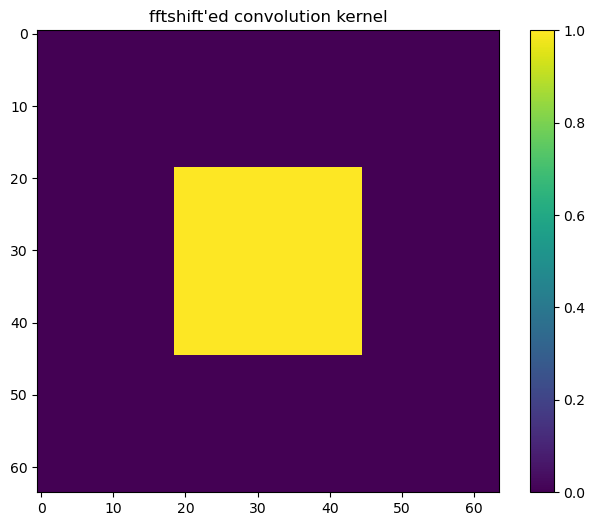

In [7]:
C_lp = np.zeros([64, 64])
axis_range_x = (X >= -2) & (X <= 2)
axis_range_y = (Y >= -2) & (Y <= 2)
C_lp[axis_range_x & axis_range_y] = 1.0
C_lp = ifftshift(C_lp)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)
im = ax.imshow(fftshift(C_lp))
ax.set_title('fftshift\'ed convolution kernel')
plt.colorbar(im)

plt.show

In [8]:
def convolution_filter(x, kernel):
    return ifftn(fftn(x) * kernel)

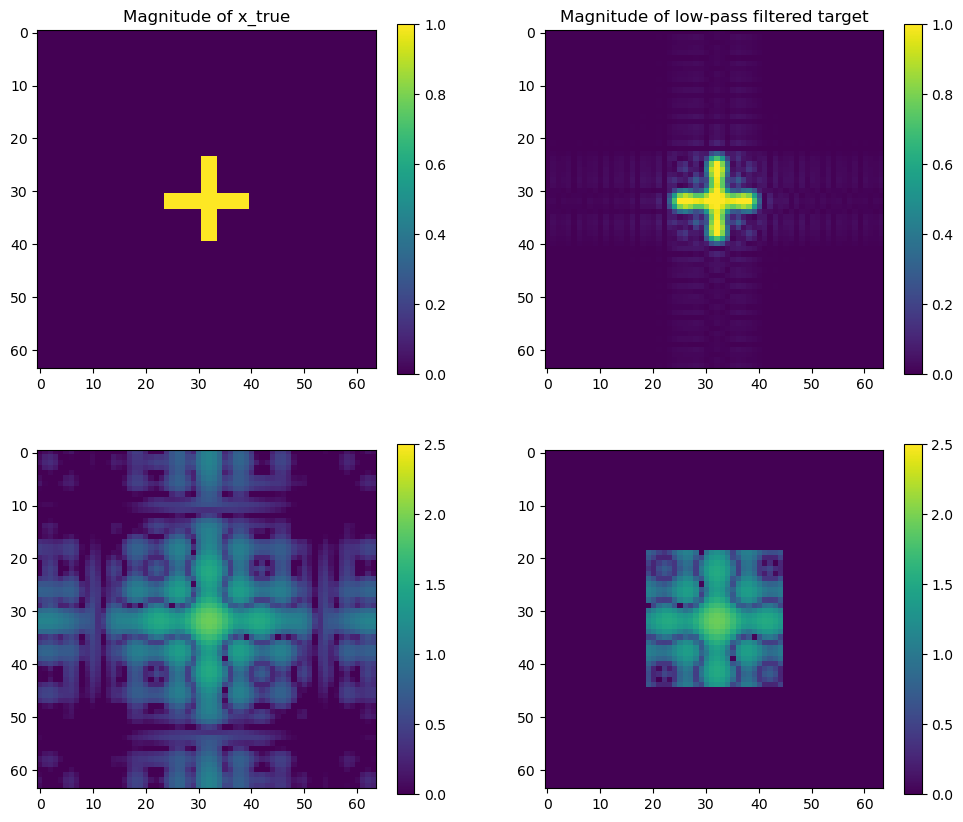

In [9]:
x_lp = convolution_filter(target, C_lp)
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(221)
im = ax.imshow(np.abs(target), clim=[0,1])  # Display the magnitude
plt.colorbar(im)
ax.set_title('Magnitude of x_true')

ax = fig.add_subplot(222)
im = ax.imshow(np.abs(x_lp), clim=[0,1])  # Display the magnitude
plt.colorbar(im)
ax.set_title('Magnitude of low-pass filtered target')

ax = fig.add_subplot(223)
im = ax.imshow(np.log10(np.abs(fftshift(fftn(target)))), clim=[0,2.5])
plt.colorbar(im)

ax = fig.add_subplot(224)
im = ax.imshow(fftshift(np.log10(np.abs(fftn(target))) * C_lp), clim=[0,2.5])
plt.colorbar(im)

plt.show()

# Phase retrieval

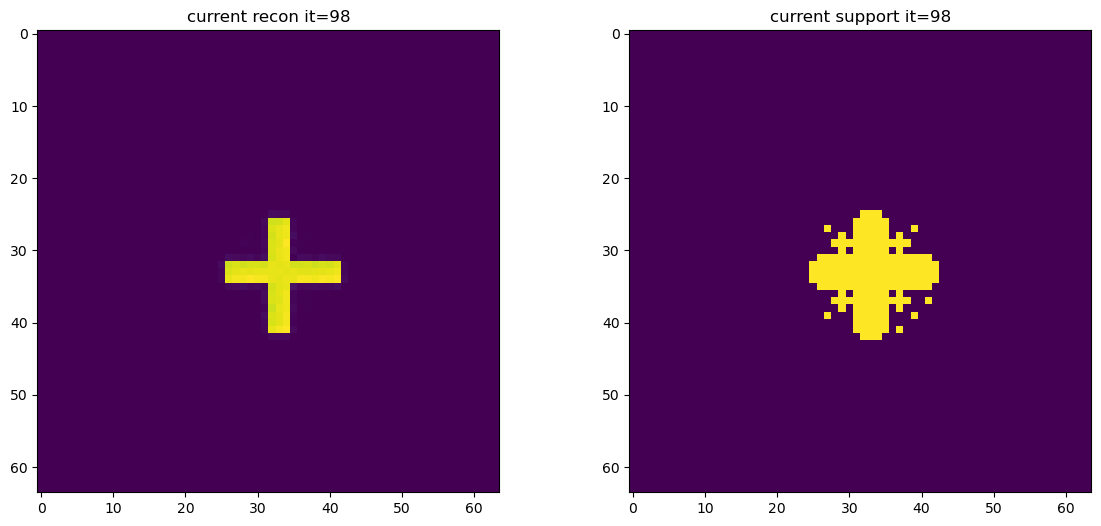

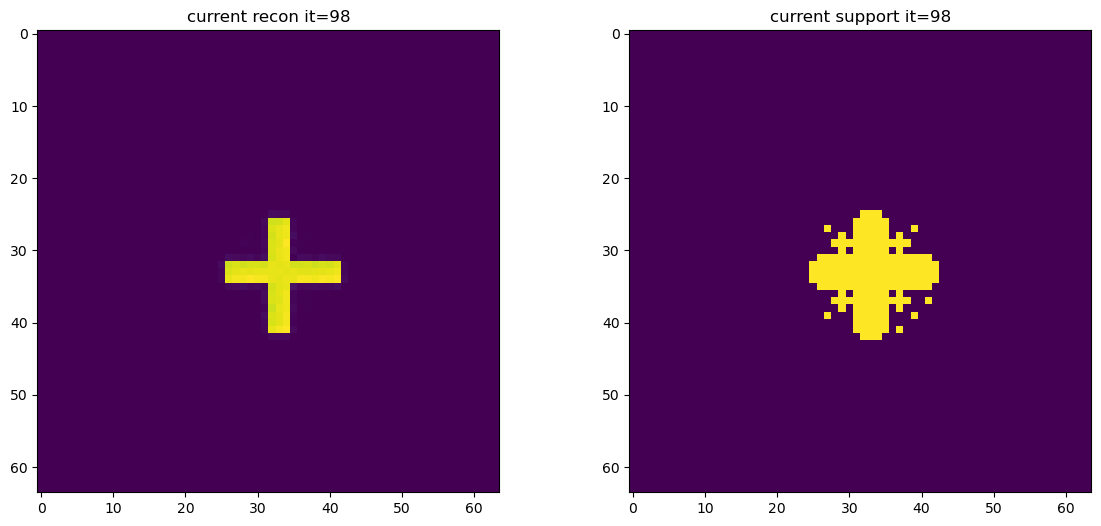

In [10]:
from IPython import display
import time

S_in = {'supp':supp}
M_in = {'M_data':M_true}

it_max = 100

beta = 0.7
gamma_M = -1/beta
gamma_S = 1/beta

x = np.random.rand(64, 64)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for it in range(it_max):
    x, x_PS = DM(x, beta, gamma_S, gamma_M, M_in, S_in)
    
    x_sol = x_PS
    
    if it % 10 == 9:
        x_mod = convolution_filter(x_sol, kernel=C_lp)
        x_mod = np.abs(x_mod)
        x_mod /= np.max(x_mod)
        supp = x_mod > 0.12
        S_in = {'supp':supp}
        
    if it % 2 == 0:
        im = ax1.imshow(np.abs(x_sol))
        ax1.set_title("current recon it=%d" % it)
        im = ax2.imshow(supp)
        ax2.set_title("current support it=%d" % it)
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        time.sleep(0.2)

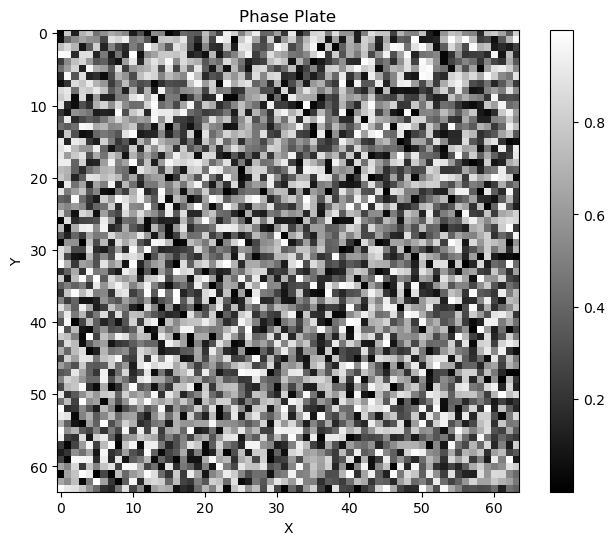